In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from misc_funcs import indexes, get_samples
from dataset_specifications.dataset import LabelledData
from networks import NoiseInjection, FeedForward, DoubleInputNetwork
from cgan_versions import WCGAN
import seaborn as sns
import pandas as pd
import evaluation as eval
import scipy.stats as ss
from sklearn import model_selection

plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Gaussian mixtures
def mu1(x):
    # return x-1.5
    return x-3 
def mu2(x):
    # return 2*x+1
    return 5*x+2
def std1(x): 
    return np.sqrt(0.4*x+0.2)
def std2(x):
    # return np.sqrt(x+1.5)
    return np.sqrt(x+1)
def pdf_func(x, x_supp, mixture_params, mixture_weights):
    y_pdf = np.zeros_like(x_supp)
    for (l, s), w in zip(mixture_params, mixture_weights):
        y_pdf += ss.norm.pdf(x_supp, loc=l(x), scale=s(x))*w
    return y_pdf

w = 0.65 #weight
n = 5000 #number of samples

In [6]:
mixture_params = np.array([[mu1,std1],[mu2, std2]])
mixture_n_comp = mixture_params.shape[0]
mixture_weights = np.array([1-w, w])
mixture_idx = np.random.choice(mixture_n_comp, size = n, p = mixture_weights)

In [7]:
# Sampling from GM
x_samples = np.random.uniform(low=0, high=1, size=n)
y_samples = []
for idx, i in enumerate(mixture_idx):
    mean = mixture_params[i,0]
    std = mixture_params[i,1]
    sample = ss.norm.rvs(loc=mean(x_samples[idx]), scale=std(x_samples[idx]))
    y_samples.append(sample)

In [8]:
# Make sure that GM from above corresponds to data imported below
combined = np.stack((x_samples, y_samples), axis=1)
combined_train, combined_test = model_selection.train_test_split(combined, test_size=0.3, random_state=43)

#export data
DATASET_PATH = './datasets'
DATASET_NAME = 'GM'

np.savetxt("./{}/{}/train.csv".format(DATASET_PATH,DATASET_NAME), combined_train,delimiter=",")
np.savetxt("./{}/{}/val.csv".format(DATASET_PATH,DATASET_NAME), combined_test,delimiter=",")

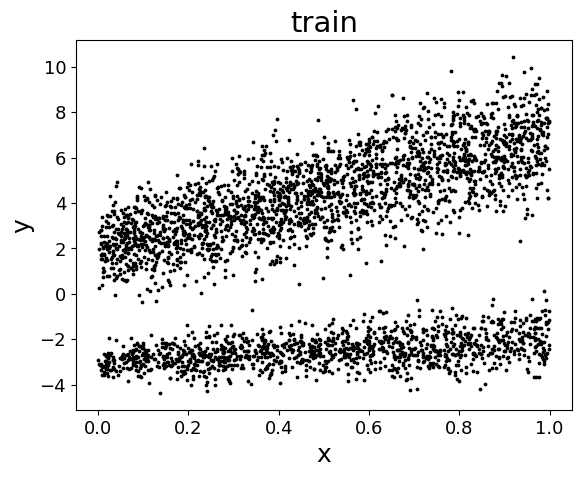

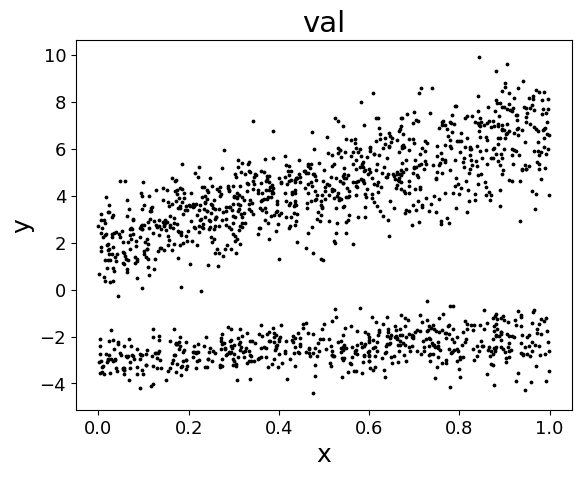

In [9]:
#import data
DATASET_PATH = './datasets'
DATASET_NAME = 'GM'
dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

splits = {}
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
X_DIM = 1
Y_DIM = 1
scatter_plot = 1

for split in ("train","val"):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k', s=3)
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        plt.show()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data = splits["train"]
val_data = splits['val']

# train_tab = TabularDataset(train_data)
# train_tab[0]


In [10]:
# path for saving parameters of model
PARAM_PATH = './param_best'
FILE_NAME = '1D_GM_WCGAN'

# For saving plots
PLOT_PATH = './plots'
PLT_DATASET_NAME = '1D_GM'


constants = {
    "dataset_path": DATASET_PATH,
    "dataset_name": DATASET_NAME,
    # "channel_name": CHANNEL_NAME,
    "plot_path": PLOT_PATH,
    "plt_dataset_name": PLT_DATASET_NAME,
    "param_path": PARAM_PATH,
    "file_name": FILE_NAME,
    "x_dim": X_DIM,
    "y_dim": Y_DIM
}

In [11]:
def val_func(model, epoch):
    return eval.evaluate_model(model, data = val_data, data_train = train_data, data_test = None, epoch = epoch)

Epoch 49, true	ll: -3.267	mae: 3.339	Wasserstein-2 dist: 1.0525
Epoch 99, true	ll: -2.3391	mae: 3.1647	Wasserstein-2 dist: 0.18692
Epoch 149, true	ll: -2.259	mae: 3.1221	Wasserstein-2 dist: 0.12772
Epoch 199, true	ll: -2.147	mae: 3.177	Wasserstein-2 dist: 0.12147
Epoch 249, true	ll: -2.395	mae: 3.3656	Wasserstein-2 dist: 0.18992
Epoch 299, true	ll: -2.3706	mae: 3.1222	Wasserstein-2 dist: 0.2121
Epoch 349, true	ll: -2.2025	mae: 3.0828	Wasserstein-2 dist: 0.18233
Epoch 399, true	ll: -2.309	mae: 3.2425	Wasserstein-2 dist: 0.14627
Epoch 449, true	ll: -2.3503	mae: 3.3725	Wasserstein-2 dist: 0.27748
Epoch 499, true	ll: -2.3845	mae: 3.0695	Wasserstein-2 dist: 0.17825
Epoch 549, true	ll: -2.1645	mae: 3.0809	Wasserstein-2 dist: 0.10892
Epoch 599, true	ll: -2.1034	mae: 3.0867	Wasserstein-2 dist: 0.15446
Epoch 649, true	ll: -2.1679	mae: 3.2352	Wasserstein-2 dist: 0.297
Epoch 699, true	ll: -2.2516	mae: 3.0707	Wasserstein-2 dist: 0.17577
Epoch 749, true	ll: -2.0696	mae: 3.0979	Wasserstein-2 dist: 0

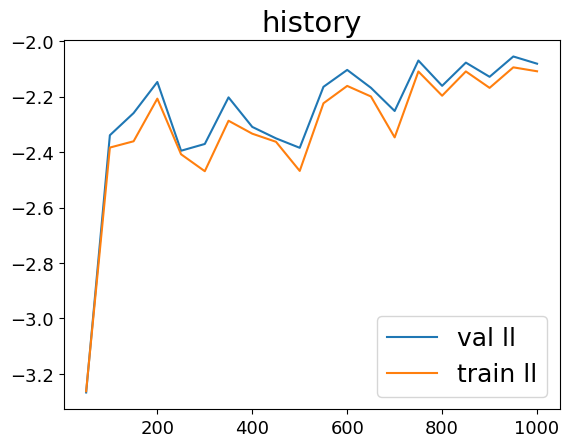

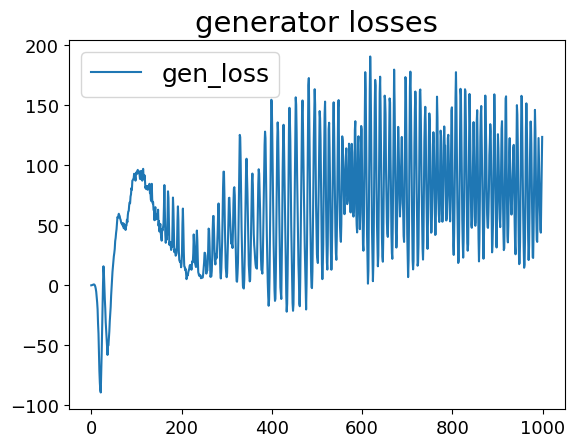

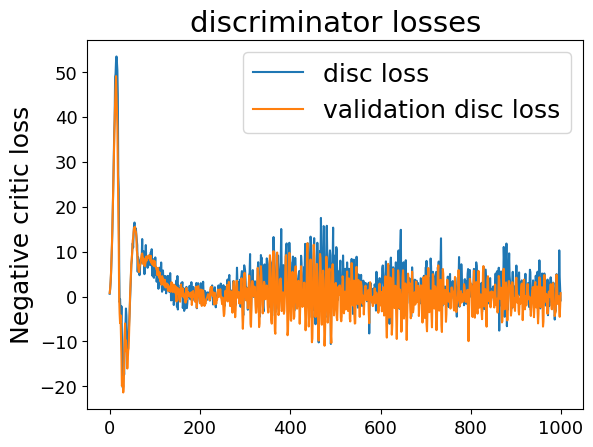

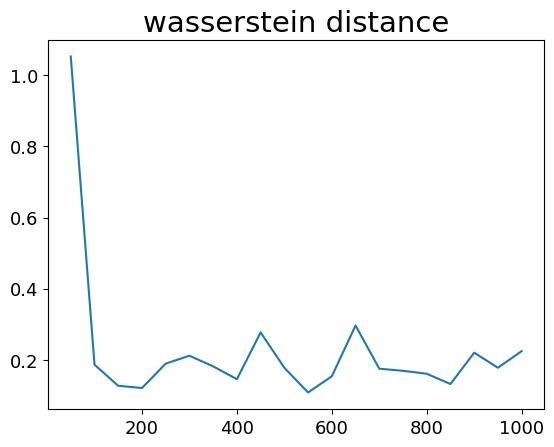

In [12]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 2,
    "epochs": 1000,
    "batch_size": 400,
    "gen_lr": 2e-4,
    "disc_lr": 2e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "pdf_index":0,
    "scatter": 1,
    "kde_batch_size": 10,
    "n_critic": 5,
    "lambda_gp": 0.01,
    'one-sided': False
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [400,400,400],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": NoiseInjection,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [400,400,400],
    # "cond_layers": [64,64],
    # "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation":nn.ReLU(),
    "type": FeedForward,
    "dropout": None,
    "activation_final": 0,
    "spectral_normalisation": None
}
}

wcgan_model = WCGAN(config, nn_spec, constants)
wcgan_model.train(train_data, val_data, val_func)

Text(0.5, 1.0, 'x=5')

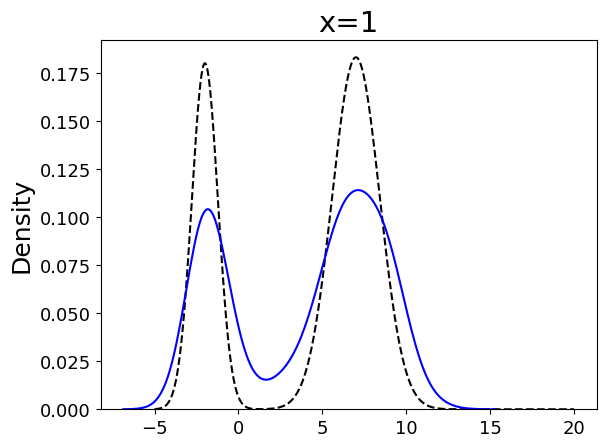

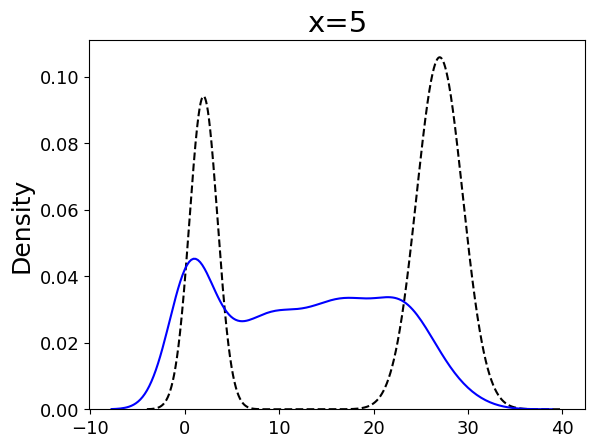

In [13]:
xs = 1
xs2 = 5 #unseen
x_pdf = np.linspace(-5,20,n)#support of pdf
x_pdf2 = np.linspace(-4,40,n)#support of pdf

y_pdf = pdf_func(xs,x_pdf,mixture_params, mixture_weights)
y_pdf2 = pdf_func(xs2,x_pdf2,mixture_params, mixture_weights)

# # Sample from model
y_gen = get_samples(wcgan_model,xs).numpy()
plt.figure()
plt.plot(x_pdf, y_pdf, color ='k', linestyle='--',label='x={}'.format(xs))
sns.kdeplot(y_gen.squeeze(),color='b')
plt.title('x={}'.format(xs))
plt.figure()
plt.plot(x_pdf2, y_pdf2, color ='k', linestyle='--')
y_gen2 = get_samples(wcgan_model,xs2)
sns.kdeplot(y_gen2.squeeze(),color='b', legend=True)
plt.title('x={}'.format(xs2))